# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

# Part 0 Initialization

## 0.0 Import necessary module

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
# Import necessary modules
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

In [3]:
import os
# import cv2 as cv2
import matplotlib.mlab
from collections import defaultdict
from functools import reduce

from skimage import measure
from scipy.optimize import curve_fit
from scipy.signal import medfilt
from scipy.stats import norm

In [4]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

## 0.2 Load data

In [5]:
# Load images 
os.listdir('../data/project-data/')
data_dir = '../data/project-data/'

img_dict = dict()
gt_dict = dict()
img_types = ['train', 'validation', 'test']

for img_type in img_types:
    
    # Get file names
    with open(f'{data_dir}/{img_type}.txt', 'r') as f:
        
        filenames = f.read().split('\n')
        
    # Get images
    img_dict[img_type] = skimage.io.imread_collection([f'{data_dir}/images/{img_type}/{img_name}.jpg'
                                                      for img_name in filenames])
    
    # Get groundtruth
    gt_dict[img_type] = [parse_file(f'{data_dir}/annotations/{img_type}/{img_name}.xml')
                        for img_name in filenames]
    

# 1. Thresholding

In [8]:
# Get histogram of pixel values
k = 11
gray_img = skimage.color.rgb2gray(img_dict['train'][k]) * 256

## 1.1 Preprocess by smoothing

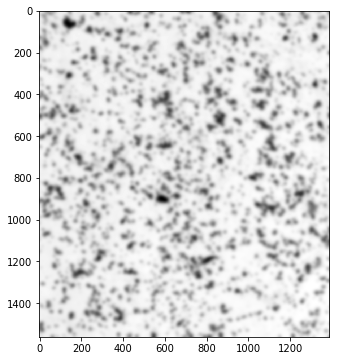

In [9]:
from scipy.signal import wiener

from scipy.ndimage.filters import gaussian_filter

tmp_median_smoothed = gaussian_filter(gray_img, 8)

fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
ax.imshow(tmp_median_smoothed, cmap = 'gray')

Unclear whether smoothing is useful. Need more investigation.

## 1.2 Find threshold to separate foreground and background

1. Gaussian fitting
  Fit gaussian to the gray level histogram and find the intersection of two gaussian as separating threshold.

2. Heuristic method
  Decide the threshold based on heuristics. 

In [10]:
def gauss(x, mean, sigma, A):
    
    return A * np.exp(-1 * (x - mean) ** 2 / (2 * sigma ** 2))

def bimodal(x, mean_f, sigma_f, A_f, mean_b, sigma_b, A_b):
    
    return gauss(x, mean_f, sigma_f, A_f) + gauss(x, mean_b, sigma_b, A_b)

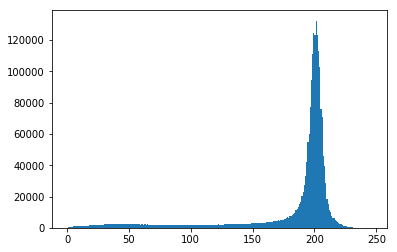

In [10]:
# Get count of pixels for each bins of gray values
counts, bins, _ = plt.hist(gray_img.ravel(), bins = 256)

In [11]:
# Initialize fore/back ground separation boundary
thrs_estimated = 100

In [12]:
# Fit gaussian to the white part
white_params, _ = curve_fit(gauss, np.arange(256 - thrs_estimated), counts[thrs_estimated: ])

# Fit gaussian to black part
black_params, _ = curve_fit(gauss, np.arange(thrs_estimated), counts[: thrs_estimated])

Text(0.5, 1.0, 'Black')

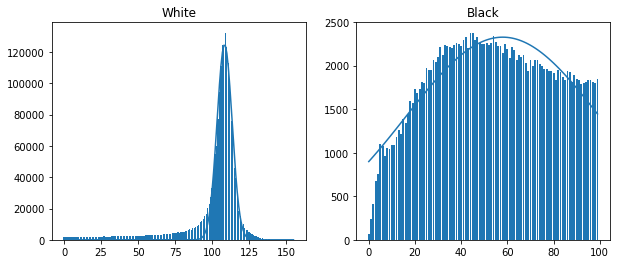

In [13]:
# Visualize the gaussian fit
fig = plt.figure(figsize = (10, 4))

# Plot white part
ax = fig.add_subplot(121)
ax.bar(np.arange(256 - thrs_estimated), counts[thrs_estimated:])
ax.plot(np.arange(256 - thrs_estimated), gauss(np.arange(256 - thrs_estimated), *white_params))
ax.set_title('White')

# Plot black part
ax = fig.add_subplot(122)
ax.bar(np.arange(thrs_estimated), counts[: thrs_estimated])
ax.plot(np.arange(thrs_estimated), gauss(np.arange(thrs_estimated), *black_params))
ax.set_title('Black')

In [11]:
# Find the threshold minimizing classification into foreground and background
def find_gaussian_intersection(mean_1, sigma_1, A_1, mean_2, sigma_2, A_2):
    """
    Find value where two gaussian have same probability
    Params: mean_1: mean of first gaussian
            sigma_1: std of first gaussian
            A_1: amplitude of first gaussian
            mean_2: mean of second gaussian
            sigma_2: std of second gaussian
            A_2: amplitude of second gaussian
    Return: intersection value
    """
    
    # Reduce the problem of solving a quadratic equation
    
    # Find second order param
    sec_param = (1 / (2 * sigma_2 ** 2) - 1 / (2 * sigma_1 ** 2))

    # Find first order param
    first_param = mean_1 / sigma_1 ** 2 - mean_2 / sigma_2 ** 2

    # Find constant param
    constant_param = mean_2 ** 2 / (2 * sigma_2 ** 2) - mean_1 ** 2 / (2 * sigma_1 ** 2) + \
                        np.log(A_1) - np.log(A_2)
    
    return np.roots([sec_param, first_param, constant_param])[1]

In [15]:
# Get threshold of foreground and background
thrs = find_gaussian_intersection(*white_params, *black_params)

In [16]:
print(f'Gaussian fitting results in separation threshold of {thrs}')

Gaussian fitting results in separation threshold of 93.42003788381324


In [17]:
# Map the image to binary img using threshold
bi_img = gray_img < thrs

Text(0.5, 1.0, 'Filtered by heuristic')

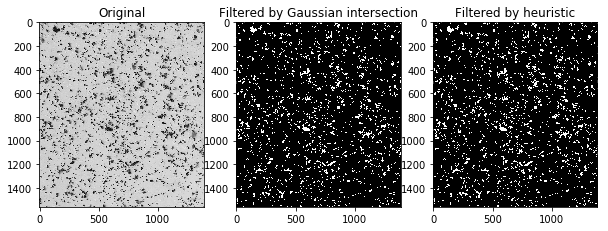

In [18]:
# Test the effect of thrs obtained from gaussian intersection
fig = plt.figure(figsize = (10, 4))
ax_list = fig.subplots(1, 3)

ax_list[0].imshow(gray_img, cmap = 'gray')
ax_list[1].imshow(bi_img, cmap = 'gray')
ax_list[2].imshow(gray_img < 100, cmap = 'gray')

ax_list[0].set_title('Original')
ax_list[1].set_title('Filtered by Gaussian intersection')
ax_list[2].set_title('Filtered by heuristic')

It is unclear whether Gaussian will outperform by heuristics as shown in the above comparisons.

For simplicity we continue with heuristics threshold.

In [12]:
# Set heuristic threshold
thrs = 100

# Get binary image by heuristic threshold
bi_img = gray_img < thrs

## 1.2 Label objects

1.2.1 Label objects using measure.label method provided in skimage module

1.2.2 Get features of detected objs including size and bounding rectangle

### 1.2.1 Conduct primitive labeling

In [13]:
# Get labels
labels = measure.label(bi_img)

In [14]:
# Illustrate labels
print(f'number of objects found are {np.max(labels) + 1}')

number of objects found are 2435


The above count show that primitive labeling cannot distinguish vorroa objs from the others since we only have tens of vorroas in an image generally.

### 1.2.2 Get size and bounding rectangle of each object

In [15]:
# Get size of detected objs
obj_sizes = dict(zip(*np.unique(labels, return_counts = True)))

# Build list of pixels for each obj
obj_pixels_alt = defaultdict(list)

for i in range(labels.shape[0]):
    
    for j in range(labels.shape[1]):
        
        obj_pixels_alt[labels[i][j]].append((i, j))

# Compute the covering rect of detected objs
obj_bbox = {k : np.asarray(cv2.boundingRect(np.asarray(obj_pixels_alt[k])))[[1, 0, 3, 2]]
            for k, v in obj_pixels_alt.items()}

# Get the area of bounding rectangle for each detected obj
obj_bbox_size = {k : obj_bbox[k][2] * obj_bbox[k][3] for k in obj_bbox.keys()}

Text(0.5, 1.0, 'Log-Log histogram of size of detected objs')

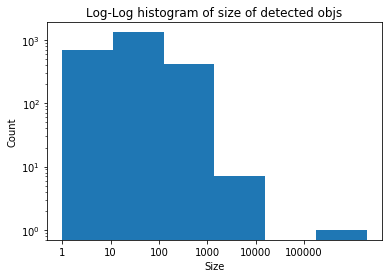

In [16]:
# Visualize the size distribution of objects
plt.hist(np.log10(list(obj_sizes.values())),
          bins = 6,
        log = True)
_ = plt.xticks(np.arange(6), [f'{10 ** s}' for s in np.arange(6)])
plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Log-Log histogram of size of detected objs')

From the distribution of size one can observe that there are two types of objs detected that should not be regarded as vorroas:

1. objects with extreme large size: these objects may be background or some unrelated objects

2. objects with extreme small size: these objects may be measurement noise

The above findings motivate us to find the thresholds for filtering objects by size.

## 1.3 Filter objects by size

1. Set thresholds by checking the distribution of vorroa's sizes in training data
2. Filter objects that are likely to be vorroa using aforementioned thresholds

### 1.3.1 Find distribution of size of vorroa

In [17]:
# Check avg vorroa size
avg_size_list = []

for i, img in enumerate(np.random.choice(gt_dict['train'], size = 500, replace = False)):
    
    # Add avg of vorroa size in this img to list
    try:
        
        avg_size_list += reduce(lambda l, item: l + [item['bbox'][2] * item['bbox'][3]],
                                   img,
                                    [])
    
    except:
        
        pass

In [18]:
# Get mean and var of size of vorroa obj
size_mean = np.mean(avg_size_list)

size_std = np.std(avg_size_list)

Text(0.5, 1.0, 'Groundtruth vorroa size distribution')

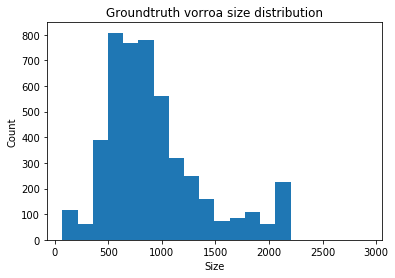

In [19]:
# Visualize the vorroa size distribution
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(avg_size_list, bins = 20)
ax.set_xlabel('Size')
ax.set_ylabel('Count')
ax.set_title('Groundtruth vorroa size distribution')

Assume that vorroa are located pairwisely independent,
Chebshev inequility indicates that by taking the size thrs to be $\mu + 3\sigma$,
we can capture about $90\%$ of vorroa objects.

So we may set the upper bound of size of an valid vorroa obj to be that value.

In [20]:
# Set upper size threshold
up_size_thrs = size_mean + 3 * size_std

By heuristics we may set the lower bound of size of an valid vorroa to be 350.

In [21]:
# Set lower size threshold
low_size_thrs = np.float64(350)

### 1.3.2 Filter detected obj based on size thresholds found.

In [22]:
# Filter the detected obj by size_thrs
obj_mask = np.where((list(obj_sizes.values()) > low_size_thrs) *\
                    (list(obj_sizes.values()) < up_size_thrs),
                    1,
                    0)

In [23]:
# Get the filtered objs
obj_bbox_values = list(obj_bbox.values())
filtered_objs = np.asarray([obj_bbox_values[i] for i in range(len(obj_mask)) if obj_mask[i]])

Text(0.5, 1.0, 'Groundtruth: Red   Detected: Steelblue')

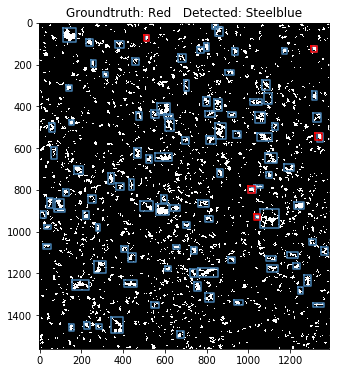

In [27]:
# Visualize the filtered objs on the binary figure
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)

# Show img
ax.imshow(bi_img, cmap = 'gray')

# Show detected objs
for obj in filtered_objs:
    
    ax.plot([obj[0], obj[0] + obj[2], obj[0] + obj[2], obj[0], obj[0]],
           [obj[1], obj[1], obj[1] + obj[3], obj[1] + obj[3], obj[1]],
           c = 'steelblue')

# Show ground truth obj
gt_objs = [item['bbox'] for item in gt_dict['train'][k]]

for obj in gt_objs:
    
    ax.plot([obj[0], obj[0] + obj[2], obj[0] + obj[2], obj[0], obj[0]],
       [obj[1], obj[1], obj[1] + obj[3], obj[1] + obj[3], obj[1]],
       c = 'red')

ax.set_title('Groundtruth: Red   Detected: Steelblue')

The results is still pretty noisy.
By observation we found out that there is possibility to filter based on density of the detected objects.

$density(obj) = \frac{\# pixels\ with\ value\ 1}{size\ of\ window}$

In [38]:
def plot_window(window, ax = None, c = None, label = None):
    """
    Plot the window
    Params: window: coordinates and length of the window
            ax: axes to plot 
            c: color
            label: label
    Return: 
    """
    
    if c == None:
        
        c = 'steelblue'
        
    if label == None:
        
        label = ''
        
    if ax != None:
        
        # Handle the case where axes to plot specified
        ax.plot([window[0], window[0] + window[2], window[0] + window[2], window[0], window[0]],
               [window[1], window[1], window[1] + window[3], window[1] + window[3], window[1]],
               c = c,
               label = label)
    
    else:
        
        # Handle the case where axes to plot not specified
        plt.plot([window[0], window[0] + window[2], window[0] + window[2], window[0], window[0]],
               [window[1], window[1], window[1] + window[3], window[1] + window[3], window[1]],
               c = c,
               label = label)

In [49]:
# Get the density for each filtered_obj
# Notice that the first coordinate actually means x0, thus is on the 2nd dimension
density = list(map(lambda window: np.sum(bi_img[window[1] : window[1] + window[3],
                                               window[0] : window[0] + window[2]]) /\
                                   (window[2] * window[3]),
                  filtered_objs))

(array([ 1.,  4.,  6., 29., 27., 16.,  8.,  8.,  2.,  4.]),
 array([0.18792517, 0.2430457 , 0.29816622, 0.35328675, 0.40840728,
        0.4635278 , 0.51864833, 0.57376886, 0.62888938, 0.68400991,
        0.73913043]),
 <a list of 10 Patch objects>)

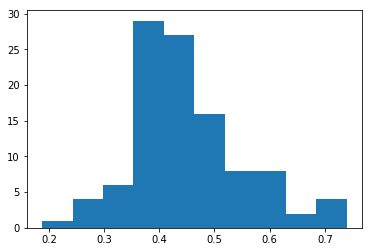

In [51]:
plt.hist(density, bins = 10)

In [53]:
# Obtain groundtruth density
gt_density = []

[[999, 782, 33, 33],
 [499, 61, 25, 27],
 [1025, 913, 30, 31],
 [1301, 113, 27, 29],
 [1320, 529, 30, 30]]

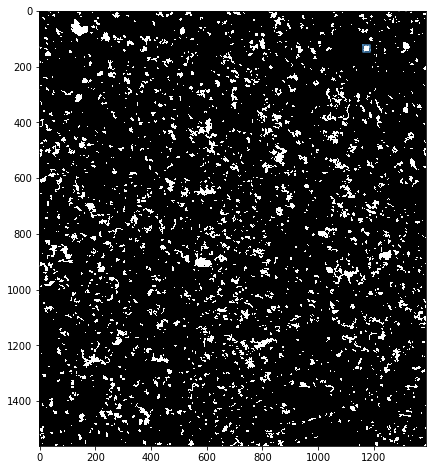

In [52]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
ax.imshow(bi_img, cmap = 'gray')
window = filtered_objs[9]
plot_window(window, ax = ax)

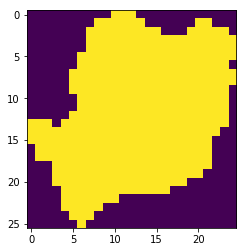

In [47]:
plt.imshow(bi_img[window[1] : window[1] + window[3],
                 window[0] : window[0] + window[2]])

In [45]:
window[0]

1161

## 1.4 Evaluation

Evaluate our segmentation results by calculating precision, recall and f1 score.

In [6]:
def calculate_IoU(a, b):
    """
    Calculate the IoU of a and b
    Params: a: (a.x, a.y, a.w, a.h)
            b: (b.x, b.y, b.w, b.h)
    Return: IoU(a, b)
    """
    
    # Calculate intersection area
    dx = min(a[0] + a[2], b[0] + b[2]) - max(a[0], b[0])
    dy = min(a[1] + a[3], b[1] + b[3]) - max(a[1], b[1])
    
    # Return zero if no intersection
    if dx <= 0 or dy <= 0:
        return 0
    
    # Set intersection area
    int_area = dx * dy
    
    # Calculate union length
    uni_area = a[2] * a[3] + b[2] * b[3] - int_area
    
    return int_area / uni_area 

In [190]:
def cal_stats(values, thrs, gtl):
    """
    Calculate precision, recall and f1_score for given thrshold
    Param: values : np.array
           thrs : double
           gtl : length of ground truth
    Return: (prec, recall, f1_score)
    """
    
    # Get boolean judgment for values using thrs
    results = np.asarray(values) > thrs
    
    # Get prec
    prec = np.sum(results) / len(values)
    
    # Get rec
    rec = np.sum(results) / gtl
    
    # Get f1_score
    f1 = 2 * prec * rec / (prec + rec)
    
    return (prec, rec, f1)

In [191]:
# Get the max IoU score for each filtered detected obj
iou_scores = [np.max([calculate_IoU(detected, gt) for gt in gt_objs]) for detected in filtered_objs]

In [192]:
# Get statistics for current img
prec, rec, f1 = cal_stats(iou_scores, thrs = 0.3, gtl = len(gt_objs))

In [193]:
print(f'Precision: {prec}\nRecall: {rec}\nF1: {f1}')

Precision: 0.0625
Recall: 1.0
F1: 0.11764705882352941


## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [59]:
THRS = 100
UP_SIZE_THRS = np.float64(2164.0)
LOW_SIZE_THRS = np.float64(350.0)

In [60]:
def detect_by_segmentation(img, thrs = THRS, up_size_thrs = UP_SIZE_THRS, low_size_thrs = LOW_SIZE_THRS):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    ''' Separate foreground and background '''
    
    # Convert img to gray scale
    gray_img = gray_img = skimage.color.rgb2gray(img) * 256
    
    # Filter img
    bi_img = gray_img < thrs
    

    ''' Label objects '''
    # Get labels
    labels = measure.label(bi_img)

    # Get size of detected objs
    obj_sizes = dict(zip(*np.unique(labels, return_counts = True)))
    
    # Formulate obj as list of pixels
    obj_pixels = defaultdict(list)

    for i in range(labels.shape[0]):

        for j in range(labels.shape[1]):

            obj_pixels[labels[i][j]].append((i, j))
            

    ''' Filter objs based on size'''
    # Compute the bounding rect of detected objs
    obj_bbox = {k : np.asarray(cv2.boundingRect(np.asarray(obj_pixels[k])))[[1, 0, 3, 2]]
                for k, v in obj_pixels.items()}

    # Filter the detected obj by size_thrs
    obj_mask = np.where((list(obj_sizes.values()) > low_size_thrs) *\
                        (list(obj_sizes.values()) < up_size_thrs),
                        1,
                        0)

    # Get the filtered objs
    obj_bbox_values = list(obj_bbox.values())
    filtered_objs = np.asarray([obj_bbox_values[i] for i in range(len(obj_mask)) if obj_mask[i]])
    
    return filtered_objs

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [76]:
# Get test imgs
test_imgs = img_dict['test']

# Get test groundtruth
test_gt = gt_dict['test']

# Get number of ground truth objs
gtl = reduce(lambda current_length, next_item: current_length + len(next_item), test_gt, 0)

# Initialize iou_scores
iou_scores_all = []

# Loop through all img to detect vorroas
for i, img in enumerate(test_imgs):
    
    # Get detected objs
    detected_objs = detect_by_segmentation(img)
    
    # Get groundtruth
    gt_img = [item['bbox'] for item in test_gt[i]]
    
    # Compute max IoU score for each detected obj
    iou_scores = [np.max([calculate_IoU(detected, gt) for gt in gt_img]) if len(gt_img) > 0 else 0 \
                  for detected in detected_objs]
    
    # Append results for this img to total results
    iou_scores_all += iou_scores

# Calculating statistics
prec, rec, f1 = cal_stats(iou_scores_all, thrs = 0.3, gtl = gtl)

In [80]:
print(f'Precision: {prec}\nRecall: {rec}\nF1: {f1}')

Precision: 0.09903121636167922
Recall: 0.4742268041237113
F1: 0.163846838824577


## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

## 2.1 Prepare data

From the vorroa size distribution, one may convince himself that setting the sliding window with length 48 and width 48 sufficies to detect all feasible vorroas.

In [7]:
def generate_crops(img, targets, step, stride, sample_negative = True):
    """
    Generate crops with window_shape from img
    Params: img: np.array
            targets: list of vorroa box
            step: window step
            stride: window stride
            sample_negative: boolean
    Return: list of crops and label while 1 represent vorroa and 0 otherwise
    """
    
    # Get groundtruth boxes from targets
    gt_box = [item['bbox'] for item in targets]
    
    # Get bounding boxes for img
    windows = list(zip(*map(lambda x: x.ravel(),
                            np.meshgrid(np.arange(0, img.shape[0] - step + 1, step / stride),
                                          np.arange(0, img.shape[1] - step + 1, step / stride),
                                                  indexing = 'xy'))))
    
    windows = np.concatenate([windows, [[step, step]] * len(windows)], axis = 1)
    
    # Get label for each bounding box using IoU
    try:
        
        # Handle the case where img contains vorroa
        labels = [np.max([calculate_IoU(detected, gt) for gt in gt_box]) > 0.5 for detected in windows]
    
    except:
        print('exception')
        # Handle the case where img does not contain vorroa
        labels = [0] * len(windows)
        
    # Get window crops
    print(img.strides)
    window_crops = np.lib.stride_tricks.as_strided(img,
                                                shape = [len(np.arange(0, 
                                                                       img.shape[0] - step + 1,
                                                                       step / stride)),
                                                         len(np.arange(0, 
                                                                       img.shape[1] - step + 1,
                                                                       step / stride)), 
                                                         step,
                                                         step,
                                                        3],
                                                strides = [step // stride * img.strides[0],
                                                          step // stride * img.strides[1],
                                                          img.strides[0],
                                                          img.strides[1],
                                                          1])

    print(window_crops.shape)
    # Reshape window crops and labels
    window_crops = window_crops.reshape(-1, step, step, 3)
    labels = np.asarray(labels)

    # Get positive window pos
    pos_windows = windows[np.where(labels == 1)]
    
    ''' Randomly drop some non vorroa windows'''
    if sample_negative:
        # Get vorroa window and non vorroa window indices
        vorroa_indices = np.where(labels == 1)[0]

        non_vorroa_indices = np.where(labels == 0)[0]

        # Get indices of 100 non-vorroa windows to keep
        keep_non_vorroa_indices = non_vorroa_indices[np.random.randint(0, len(non_vorroa_indices), 100)]

        # Construct windows and labels to return
        window_crops = window_crops[np.concatenate([vorroa_indices, keep_non_vorroa_indices])]

        labels = labels[np.concatenate([vorroa_indices, keep_non_vorroa_indices])]
    
    return window_crops, labels, pos_windows

In [ ]:
gray_img = skimage.color.rgb2gray(img_dict['train'][k]) * 256

In [147]:
tmp_img = img_dict['train'][9]

(5538, 3, 1)
(127, 171, 32, 32, 3)


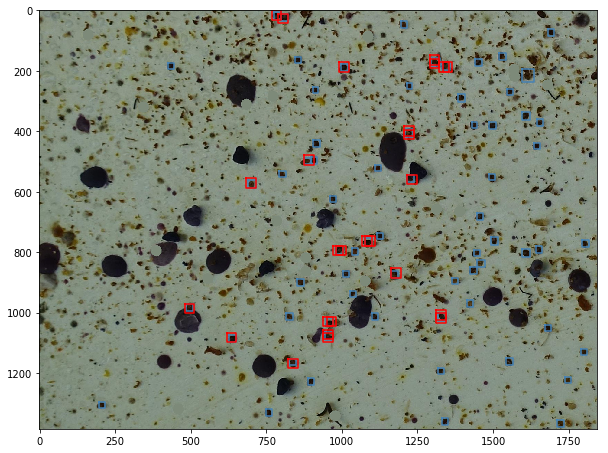

In [200]:
# Check recall and precision of vorroa window extraction
i = 20

window_crops, labels, pred_windows = generate_crops(img_dict['train'][i],
                                       gt_dict['train'][i],
                                       step = 32,
                                       stride = 3)

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
tmp_img = img_dict['train'][i]
ax.imshow(tmp_img)
gt_labels = gt_dict['train'][i]
gt_labels = [item['bbox'] for item in gt_labels]

for window in gt_labels:
    
    plot_window(window, ax)
    
positive_window_crops = pred_windows[np.where(labels == 1)]

for window in positive_window_crops:
    
    plot_window(window, ax, c = 'red')

The step of window cropping scheme results in the low recall of adaptive crop labeling algorithm.

Now let's try on manually building positive windows.

The histogram illustrates that window size of 48 * 48 captures the majority of vorroas

Now let's boost each groundtruth window to size of 48 * 48


In [252]:
# Get groudtruth windows
gt_windows = []

for i, img_windows in enumerate(gt_dict['train']):
    
    # Get img height and width
    height, width, _ = img_dict['train'][i].shape
    for item in img_windows:
        
        gt_windows += [item['bbox']]

KeyboardInterrupt: 

In [371]:
img = img_dict['train'][20]
windows = gt_dict['train'][20]
windows = [item['bbox'] for item in windows]

In [8]:
window_width, window_height = 48, 48

In [9]:
def expand_window(img, gt_windows, window_width = 48, window_height = 48):
    """
    Expand window of img to (window_width, window_height)
    Params: img: (n, m, 3) array
            gt_windows: list of windows
            window_width: width
            window_height: height
    Return: list of expanded windows
    """

    # Get height and width of img
    height, width, _ = img.shape
    results = []
    
    for window in gt_windows:

        # Get x dimension increment to make
        delta_x = window_width - window[2]

        # Get y dimension increment to make
        delta_y = window_height - window[3]

        if window[0] < (delta_x // 2):
            # Handle the case where left space is not enough

            x_new = 0

        elif window[0] + window[2] + (delta_x - delta_x // 2) >= width:
            # Handle the case where right space is not enough

            x_new = width - 1 - window_width

        else:
            # Handle normal case

            x_new = window[0] - delta_x // 2

        if window[1] < (delta_y // 2):
            # Handle the case where upper space is not enough

            y_new = 0

        elif window[1] + window[3] + (delta_y - delta_y // 2) >= height:
            # Handle the case where lower space is not enough

            y_new = height - 1 - window_width

        else:

            y_new = window[1] - delta_y // 2

        results.append([x_new, y_new, window_width, window_height])
    
    return results

In [10]:
def construct_training_crops(img, windows, window_width = 48, window_height = 48, negative_increment = 5):
    """
    Construct training crops from img with specific window height and width
    Return: [positive_crops, negative_crops]
    """
    
    """ Build positive samples by expanding the gt window to required shape """
    expanded_windows = expand_window(img, windows)

    vorroa_crops = [img[window[1] : window[1] + window[3], window[0] : window[0] + window[2]] \
                   for window in expanded_windows]

    """ Build negative samples by random sampling """

    # Define sample size for each img
    negative_sample_size = len(vorroa_crops) + negative_increment

    # Sample starting point
    negative_x = np.random.choice(img.shape[1] - window_width, negative_sample_size)
    negative_y = np.random.choice(img.shape[0] - window_height, negative_sample_size)

    # Construct windows
    negative_windows = list(zip(negative_x,\
                                negative_y,\
                                np.ones(len(negative_x)).astype(np.int) * window_width,\
                                np.ones(len(negative_x)).astype(np.int) * window_height))

    # Filter windows overlapping vorroa windows
    if len(vorroa_crops) > 0:
        
        negative_windows = list(filter(lambda window: np.max([calculate_IoU(window, gt_window)\
                                           for gt_window in expanded_windows]) < 0.3,
                   negative_windows))

    # Get the content of negative window
    negative_crops = [img[window[1] : window[1] + window[3], window[0] : window[0] + window[2]] \
                   for window in negative_windows]

    negative_crops = np.asarray(negative_crops)
    
    if len(vorroa_crops) == 0:
        
        return negative_crops, [0] * len(negative_crops)
    
    else:
        
        return np.concatenate([vorroa_crops, negative_crops]), np.concatenate([[1] * len(vorroa_crops),
                                                                          [0] * len(negative_crops)])

In [11]:
crops, labels = [], []

In [12]:
for i in range(len(gt_dict['train'])):
    
    # Get img
    img = img_dict['train'][i]
    
    # Get gt_windows
    gt_windows = gt_dict['train'][i]
    
    gt_windows = [item['bbox'] for item in gt_windows]
    
    # Get crops and labels
    current_crops, current_labels = construct_training_crops(img, gt_windows)
    
    # Update crops and labels
    try:
        
        crops = np.concatenate([crops, current_crops], axis = 0)
    
    except:
        
        crops = current_crops
    
    labels = np.concatenate([labels, current_labels])

(array([ 9.,  6.,  2.,  4.,  5.,  5.,  1.,  8.,  7.,  8.,  3., 12.,  7.,
         2.,  4.,  5.,  2.,  4.,  1.,  3.]),
 array([ 1.43565518,  3.92642989,  6.41720461,  8.90797933, 11.39875405,
        13.88952876, 16.38030348, 18.8710782 , 21.36185291, 23.85262763,
        26.34340235, 28.83417707, 31.32495178, 33.8157265 , 36.30650122,
        38.79727593, 41.28805065, 43.77882537, 46.26960008, 48.7603748 ,
        51.25114952]),
 <a list of 20 Patch objects>)

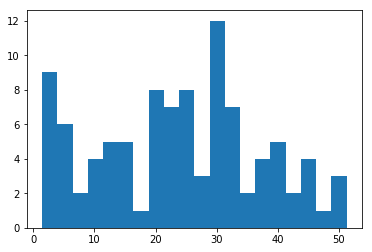

In [355]:
# Check the content of negative crops by computing the std
plt.hist([np.mean(np.std(negative_crops[i], axis = (0, 1))) \
          for i in range(len(negative_windows))], bins = 20)

May need to filter contentless crops.

In [13]:
# Store data to file
np.save('window_crops', crops)

np.save('labels', labels)

Please load them from local file directly once created.

In [6]:
window_crops = np.load('window_crops.npy')

labels = np.load('labels.npy')

## 2.2 Classification

### 2.2.1 SVC

In [8]:
from sklearn.svm import SVC

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [11]:
# Build training data with balanced samples from positive and negative class
positive_index = np.where(labels == 1)[0]

negative_index = np.where(labels == 0)

In [12]:
""" Randomly sample negative input """

# Get the number of positive samples
num_positive = len(positive_index)

# Get random indices of num_positive negative samples
filtered_negative_index = np.random.choice(negative_index[0], size = num_positive, replace = False)

In [13]:
# Sample data for model building
filtered_window_crops = window_crops[np.concatenate([positive_index, filtered_negative_index])]
filtered_labels = labels[np.concatenate([positive_index, filtered_negative_index])]

In [17]:
# Shuffle data
shuffle_indices = np.random.permutation(len(filtered_labels))
filtered_window_crops = filtered_window_crops[shuffle_indices]
filtered_labels = filtered_labels[shuffle_indices]

In [184]:
# Truncate data
m = 4000
filtered_window_crops = filtered_window_crops[: m]
filtered_labels = filtered_labels[: m]

In [185]:
# Build train test split
x_train, x_test, y_train, y_test = train_test_split(filtered_window_crops.reshape((-1, 48 * 48 * 3)),
                                                    filtered_labels,
                                                   test_size = 0.2)

In [186]:
""" Normalize training and testing data"""

x_mean = np.mean(x_train, axis = 0)

x_std = np.std(x_train, axis = 0)

x_train = (x_train - x_mean) / x_std

x_test = (x_test - x_mean) / x_std

In [187]:
# Build classifier 
svc = SVC()

In [188]:
# Train
svc.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [189]:
# Find training prediction
y_train_pred = svc.predict(x_train)

In [190]:
# Find testing prediction
y_test_pred = svc.predict(x_test)

In [191]:
print(f'Testing accuracy is {np.mean(y_test_pred == y_test)}')
print(f'Testing precision is {precision_score(y_test, y_test_pred)}')
print(f'Testing recall is {recall_score(y_test, y_test_pred)}')
print(f'Testing f1 score is {f1_score(y_test, y_test_pred)}')

Testing accuracy is 0.6825
Testing precision is 0.7064676616915423
Testing recall is 0.6761904761904762
Testing f1 score is 0.6909975669099757


The testing results seems to be acceptable.

Now let's apply the classifier to the testing img.

In [207]:
# Get testing img and label
k = 20
test_img = img_dict['test'][k]

test_gt = gt_dict['test'][k]

#test_gt = [item['bbox'] for item in test_gt]

In [208]:
test_crops, test_crop_labels = generate_crops(test_img, test_gt, 48, 1, sample_negative = False)

(38, 34, 48, 48, 3)


In [209]:
# Normalize test data
test_crops = test_crops.reshape(-1, 48 * 48 * 3)

In [210]:
test_crops = (test_crops - x_mean) / x_std

In [211]:
# Predict for test data
test_pred = svc.predict(test_crops)

In [212]:
# Get number of crops on horizontal and vertical axis

step = 48
hori_count = len(range(0, test_img.shape[1] - step + 1, step))
verti_count = len(range(0, test_img.shape[0] - step + 1, step))

In [213]:
# Fill prediction to test img
test_results = np.ones(test_img.shape)

In [214]:
for i in range(hori_count):
    
    for j in range(verti_count):
        
        test_results[i * step : (i + 1) * step, j * step : (j + 1) * step] *= test_pred[hori_count * i + j]

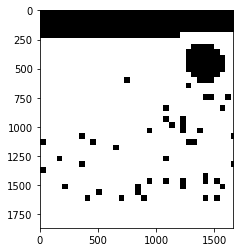

In [215]:
plt.imshow(test_results)

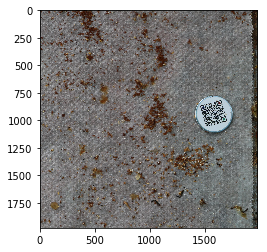

In [182]:
plt.imshow(test_img)

In [125]:
padded_img = cv2.copyMakeBorder(test_img, 24, 24, 24, 24, borderType = cv2.BORDER_REFLECT)

In [3]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [4]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

### 3.0 Initialization

In [8]:
# Import necessary modules
import keras

Using TensorFlow backend.


In [19]:
# Load data
window_crops = np.load('window_crops.npy')

labels = np.load('labels.npy')

### 3.1 Build training and validation data

In [9]:
# Set train_validation split ratio
train_val_ratio = 0.8

# Shuffle data
shuffle_indices = np.random.permutation(np.arange(labels.shape[0]))

window_crops = window_crops[shuffle_indices]

labels = labels[shuffle_indices]

In [10]:
# Get positive and negative indices
positive_indices = np.where(labels == 1)[0]

# To boost recall we only sample a subset of negative samples
negative_indices = np.where(labels == 0)[0][: len(positive_indices)]

# Get train and validation indices
train_indices = np.concatenate([positive_indices[: int(train_val_ratio * len(positive_indices))],
                               negative_indices[: int(train_val_ratio * len(negative_indices))]])

val_indices = np.concatenate([positive_indices[int(train_val_ratio * len(positive_indices)) :],
                               negative_indices[int(train_val_ratio * len(negative_indices)) :]])

# Build training data
x_train = window_crops[train_indices]

y_train = labels[train_indices]

# Build validation data
x_val = window_crops[val_indices]

y_val = labels[val_indices]

In [11]:
def preprocess(x, y = [], num_classes = 2):
    """
    Preprocess by normalizing x to [0, 1], y to (N, num_classes)
    Params: x: features
            y: labels
            num_classes
    Return: x_normalized, y_categorical
    """

    # Normalize training and validation data
    x = x.astype('float32')
    x /= 255
    
    if len(y) == 0:
        return x
    
    # Convert class vectors to binary class matrices
    y = keras.utils.to_categorical(y, num_classes)
    
    return x, y

In [12]:
# Preprocess
x_train, y_train = preprocess(x_train, y_train)
x_val, y_val = preprocess(x_val, y_val)

In [13]:
# Get input shape
input_shape = x_train.shape[1 : ]

### 3.2 Build and train classifier

In [14]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


In [15]:
# Define hyperparameters
batch_size = 128
num_classes =  2
epochs = 12

In [16]:
model = Sequential()

# Add first convolution layer
model.add(Conv2D(filters = 32,
                 kernel_size = (3, 3),
                activation = 'relu', 
                input_shape = input_shape))

# Add second convlution layer
model.add(Conv2D(filters = 64,
                 kernel_size = (3, 3),
                activation = 'relu'))

# Add first max pooling layer
model.add(MaxPooling2D(pool_size = (2, 2)))

# Add first dropout layer
model.add(Dropout(0.25))

# Flatten 
model.add(Flatten())

# Add first dense layer
model.add(Dense(128, activation = 'relu'))

# Add 2nd dropout layer
model.add(Dropout(0.5))

# Add classification layer
model.add(Dense(num_classes,
                activation = 'softmax'))

In [17]:
# Define loss, optimization scheme
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adadelta(),
             metrics = ['accuracy'])

In [18]:
# Train
model.fit(x_train, y_train,
         batch_size = batch_size,
         epochs = epochs,
         verbose = 1,
         validation_data = (x_val, y_val))

Train on 11972 samples, validate on 2994 samples
Epoch 1/12
 8448/11972 [====================>.........] - ETA: 31s - loss: 0.4338 - acc: 0.8544

KeyboardInterrupt: 

### 3.3 Evaluate classifier on test data

#### 3.3.1 Build test data

In [572]:
# Get x_test and y_test
test_crops, test_labels = [], []

for i in range(len(gt_dict['test'])):
    
    # Get img
    img = img_dict['test'][i]
    
    # Get gt_windows
    gt_windows = gt_dict['test'][i]
    
    gt_windows = [item['bbox'] for item in gt_windows]
    
    # Get crops and labels
    current_crops, current_labels = construct_training_crops(img, gt_windows, negative_increment = 20)
    
    # Update crops and labels
    try:
        
        test_crops = np.concatenate([test_crops, current_crops], axis = 0)
    
    except:
        
        test_crops = current_crops
    
    test_labels = np.concatenate([test_labels, current_labels])

In [578]:
# Preprocess x_test and y_test
x_test, y_test = preprocess(test_crops, test_labels)

#### 3.3.2 Evaluate on test crops

In [579]:
# Evaluate on x_test and y_test
print(f'The accuracy on test data is {model.evaluate(x_test, y_test, verbose = 1)[1]}')

2127/2127 [==============================] - 3s 2ms/step
The accuracy on test data is 0.9680300893276916


#### 3.3.3 Evaluate on full test images

We loop through all candidate crops to find the candidate vorroa window

In [599]:
for i in [20]:
    
    # Get test img
    test_img = img_dict['train'][i]
    
    # Get test img's groundtruth windows
    test_windows = gt_dict['train'][i]
    test_windows = [item['bbox'] for item in test_windows]
    
    # Generate candidate windows
    candidate_windows = list(zip(*map(lambda x: x.ravel(),
                            np.meshgrid(np.arange(0, test_img.shape[1] - window_width + 1, window_width // 2),
                                          np.arange(0, test_img.shape[0] - window_height + 1, window_height // 4),
                                                  indexing = 'xy'))))
    
    # print(candidate_windows)
    candidate_windows = np.concatenate([candidate_windows,\
                                        np.ones((len(candidate_windows), 2)) * 48],\
                                       axis = 1).astype('int')
    
    # Build candidate crops
    candidate_crops = [test_img[window[1] : window[1] + window[3],
                               window[0] : window[0] + window[2]] for window in candidate_windows]
    shapes = [candidate.shape for candidate in candidate_crops]
    candidate_crops = np.concatenate(candidate_crops).reshape(-1, window_height, window_width, 3)
    
    """ Predict for candidate crops """
    
    # Normalize candidate crops
    normalized_candidate_crops = preprocess(candidate_crops)
    
    # Predict
    y_test_pred = model.predict_classes(normalized_candidate_crops)

In [602]:
# Get predicted windows 
pred_windows = candidate_windows[y_test_pred == 1]

# Get groundtruth windows
test_windows = gt_dict['train'][20]
test_windows = [item['bbox'] for item in test_windows]

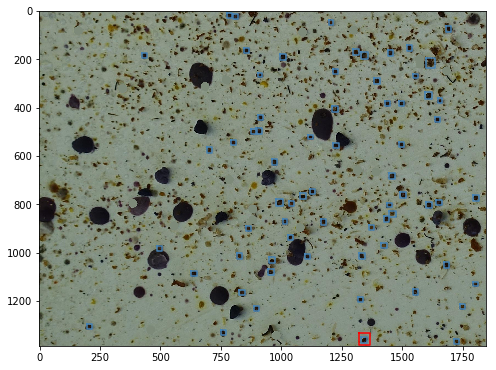

In [603]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.imshow(img_dict['train'][20])

for window in test_windows:
    
    plot_window(window)
    
plot_window(pred_windows[-1], c = 'red')

In [604]:
windows = expand_window(img_dict['train'][20], test_windows)

In [608]:
bad_window = windows[2]
model.predict_classes(np.asarray([test_img[bad_window[1] : bad_window[1] + bad_window[3],
                            bad_window[0] : bad_window[0] + bad_window[2]]\
                                  for bad_window in windows]).reshape(-1, 48, 48, 3))

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1])

In [544]:
shapes = [candidate.shape for candidate in candidate_crops]

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code